In [1]:
import numpy as np
import codecs
import array
import sys
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

In [2]:
def load_tdms(path, ch_num):
    ch = [[] for _ in range(ch_num)]
    with codecs.open(path, 'rb') as f:
        while True:
            # リードインと呼ばれる部分の読み込み
            tdms = f.read(28) 
            # print(f.tell())
            # print(tdms)
            #if b'TDSm' != tdms[:4]:
            #    continue

            # ファイルを最後まで読み込んだら終了
            if tdms==b'': 
                break

            # データとその区切りを取得
            # 次のセグメントの位置を抽出
            seg_ofs = tdms[12:20]
            by1 = array.array('l')
            by1.frombytes( seg_ofs )
            seg_ofs = np.asarray(by1)[0]
            # データの位置を抽出
            data_ofs= tdms[20:28] 
            by2 = array.array('l')
            by2.frombytes( data_ofs )
            data_ofs = np.asarray(by2)[0]

            # データのある部分まで読み飛ばす
            tdms = f.read(data_ofs)
            #print(tdms[:200], len(tdms))
            #if len(ch[0])==2:
            #    exit()
            #if len(ch[0])==0:
            #    head=tdms
            # データ部分の読み込み
            tdms = f.read(seg_ofs-data_ofs)
            by = array.array('f')
            by.frombytes( tdms )
            data = np.asarray( by )
            # print(data.shape)

            # 各チャンネルを取得
            for i in range(ch_num):
                ch[i].append( data[i::ch_num].reshape(-1,1) )

    for i in range(ch_num):
        ch[i] = np.vstack(ch[i])[:,0]

    return ch

In [3]:
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for idx in range(0, len(l), n):
        yield l[idx:idx + n]

In [ ]:
last_t = 0

from datetime import datetime
start=datetime.now()

for i in range(25, 504, 2):
    print(i)
    nc_d_path = fr'C:\Users\pmg07\Desktop\2021_1115_切削実験\dyanano\Dynamometer_{i}.tdms'
    c_d_path = fr'C:\Users\pmg07\Desktop\2021_1115_切削実験\dyanano\Dynamometer_{i+1}.tdms'

    dt = 1/(10**6)*3

    nc_d = load_tdms(nc_d_path, ch_num=3)
    c_d = load_tdms(c_d_path, ch_num=3)

    N = len(c_d[0])
    
    # linspace(開始、終了、分割数)  
    ###後から dt = 333,333に変えて、last_t + N/dtにすること
    t_d = np.linspace(last_t, last_t + N*dt, N)  
    
    # 切削距離[m]のリスト
    cd_d = t_d*(190/60)/1000
    
    # 次のパスの切削距離のスタート時点を更新する
    last_t = t_d[-1]

    #空転データの平均値を計算（切削動力計の傾き実験のy切片に当たる部分を計算）
    nc_x_a = sum(nc_d[0]) / len(nc_d[0])
    nc_y_a = sum(nc_d[1]) / len(nc_d[1])
    nc_z_a = sum(nc_d[2]) / len(nc_d[2])

    #切削動力計実験の傾き
    x_g = 0.00895
    y_g = 0.00515
    z_g = 0.00804

    
    #切削抵抗（ｘ、ｙ、ｚ）の全データのリスト
    #ドリフトを考慮した切削抵抗値（[V] ⇒ [N]の計算）
    ### 全部 z_gになっているの修正
    c_d_x = (c_d[0][:5000000] - nc_z_a)/ z_g 
    c_d_y = (c_d[1][:5000000] - nc_z_a)/ z_g 
    c_d_z = (c_d[2][:5000000] - nc_z_a)/ z_g 

    #1回転分のデータ数
    one_rotation = 3900

    #配列の長さを合わせる作業
    N = len(c_d_x)
    N_N = N - (int(N/one_rotation)) * one_rotation
    
    #切削抵抗（ｘ、ｙ、ｚ）を1回転分のデータ数(3900)ずつ区切った nparray
    c_d_x = c_d_x[:-N_N].reshape([int(N/one_rotation),one_rotation])
    c_d_y = c_d_y[:-N_N].reshape([int(N/one_rotation),one_rotation])
    c_d_z = c_d_z[:-N_N].reshape([int(N/one_rotation),one_rotation])
    
    
    #同じ行（横方向）で一番大きい値のものだけ抽出　⇒　1回転の中で一番切削抵抗が大きいものだけ抽出
    x_max = c_d_x.max(axis=1)
    y_max = c_d_y.min(axis=1)
    z_max = c_d_z.min(axis=1)
    
    #同じ行（横方向）で一番大きい値が属するインデクス番号を抽出　⇒　1回転中に切削抵抗が一番大きかったところの距離を出すだめに
    x_max_p = np.argmax(c_d_x, axis=1)
    y_max_p = np.argmin(c_d_y, axis=1)
    z_max_p = np.argmin(c_d_z, axis=1)
    
    
    #切削距離も、切削抵抗と同じ次元に合わせる作業
    cd_d = cd_d[:5000000]
    cd_d = cd_d[:-N_N].reshape([int(N/one_rotation),one_rotation])

    cd_d_x = np.array([])
    cd_d_y = np.array([])
    cd_d_z = np.array([])

    
    #1回転中に切削抵抗が一番大きかったところの切磋距離のリスト
    ###等間隔にならないので、切削距離軸を等間隔にするためにプログラム帰る必要性あり
    for j in range(int(N/one_rotation)):
        cd_d_x = np.append(cd_d_x, cd_d[j][x_max_p[j]])
        cd_d_y = np.append(cd_d_y, cd_d[j][y_max_p[j]])
        cd_d_z = np.append(cd_d_z, cd_d[j][z_max_p[j]])

    #(切削距離x,切削距離y,切削距離z,切削抵抗max_x,切削抵f抗max_y,切削抵抗max_z)をcsv保存
    dict1 = dict(x_d = cd_d_x[:], y_d = cd_d_y[:], z_d = cd_d_z[:], x = x_max[:], y = y_max[:], z= z_max[:])
    df1 = pd.DataFrame(data=dict1)
    df1.to_csv(f'./cuttingForceMax/cuttingForce_max_{i+1}.csv')
    

print(datetime.now() - start)

In [15]:
df = pd.read_csv(r'C:\Users\pmg07\M1\pr1\cuttingForceMax\cuttingForce_max_26.csv')

for i in range(28,506,2):
#     print(i)
    df_new = pd.read_csv(fr'C:\Users\pmg07\M1\pr1\cuttingForceMax\cuttingForce_max_{i}.csv')
#     print(df_new['time'][-3:-1])
    df = pd.concat([df, df_new])
#     if(i>500):
#         print(df['time'][-3:-1])
#         print(i)
print(df)

      Unnamed: 0        x_d        y_d        z_d           x           y  \
0              0   0.000000   0.000033   0.000030   59.437637  -14.818008   
1              1   0.000073   0.000074   0.000074   99.595390  -38.918213   
2              2   0.000074   0.000074   0.000074   95.652115  -38.636620   
3              3   0.000147   0.000148   0.000147   88.167910  -40.648350   
4              4   0.000153   0.000149   0.000153   95.450940  -45.033830   
...          ...        ...        ...        ...         ...         ...   
1277        1277  11.881299  11.881304  11.881299 -108.453540 -322.027250   
1278        1278  11.881340  11.881341  11.881336 -114.247940 -317.641750   
1279        1279  11.881390  11.881359  11.881365 -108.332790 -321.464050   
1280        1280  11.881404  11.881394  11.881404 -112.195640 -321.222530   
1281        1281  11.881443  11.881443  11.881434 -109.741234 -322.751500   

              z  
0     18.022550  
1    -16.579222  
2    -16.136545  
3  

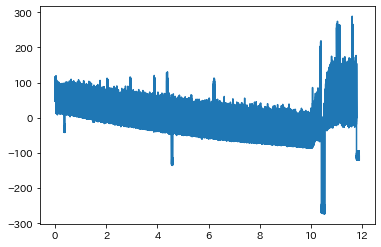

In [16]:
fig = plt.figure()
plt.plot(df['x_d'],df['x'])

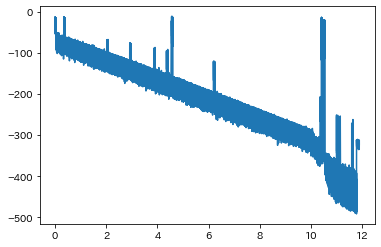

In [7]:
fig = plt.figure()
plt.plot(df['y_d'],df['y'])

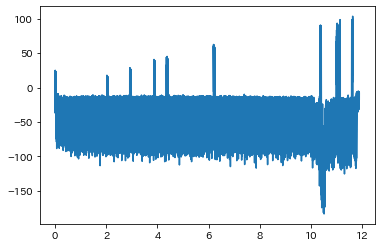

In [8]:
fig = plt.figure()
plt.plot(df['z_d'],df['z'])

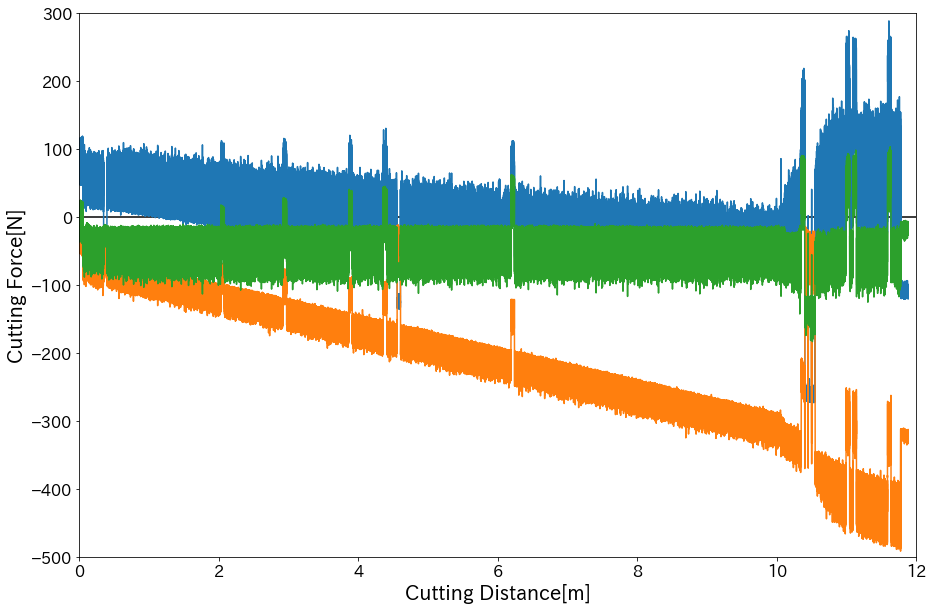

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

#全データ
p = plt.plot(df['x_d'],df['x'])
p = plt.plot(df['y_d'],df['y'])
p = plt.plot(df['z_d'],df['z'])
ax.set_xlim(0, 12)
ax.set_ylim(-500,300)

# start = 230000
# end = 230500

#ある領域
# p = plt.plot(df['x_d'][start:end],df['x'][start:end])
# p = plt.plot(df['y_d'][start:end],df['y'][start:end])
# # p = plt.plot(df['z_d'][start:end],df['z'][start:end])
# ax.set_xlim(8.885, 8.895)
# ax.set_ylim(-500,300)


p = ax.set_xlabel("Cutting Distance[m]", fontsize=20)
p = ax.set_ylabel("Cutting Force[N]", fontsize=20)
# p = ax.legend(["x","y","z"], fontsize=20)
p = plt.tick_params(labelsize=16)
p = plt.hlines([0],0,12)
fig.savefig("cutting_force_max_24-504_skiprow=400.png")

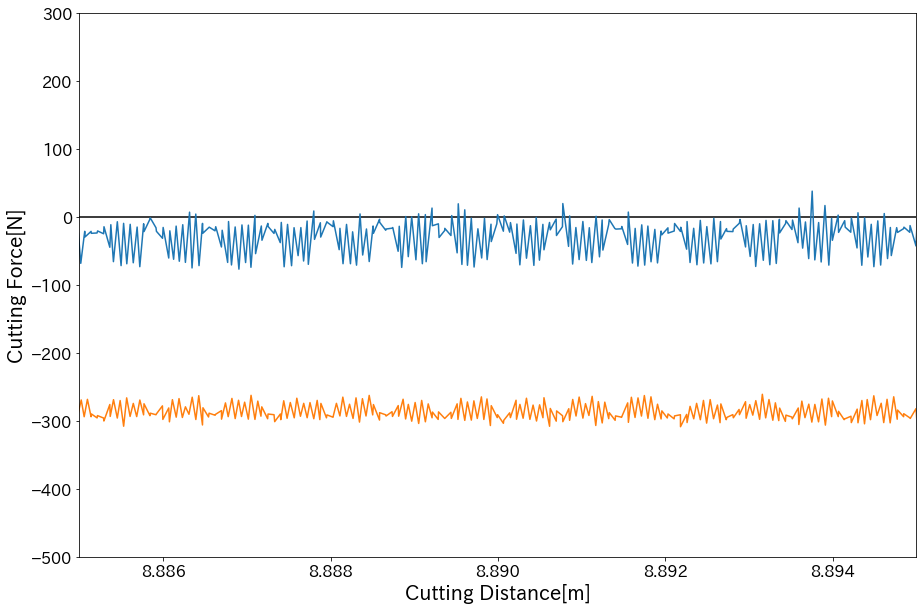

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

#全データ
# p = plt.plot(df['x_d'],df['x'])
# p = plt.plot(df['y_d'],df['y'])
# p = plt.plot(df['z_d'],df['z'])
# ax.set_xlim(0, 12)
# ax.set_ylim(-500,300)

start = 230000
end = 230500

#ある領域
p = plt.plot(df['x_d'][start:end],df['x'][start:end])
p = plt.plot(df['y_d'][start:end],df['y'][start:end])
# p = plt.plot(df['z_d'][start:end],df['z'][start:end])
ax.set_xlim(8.885, 8.895)
ax.set_ylim(-500,300)


p = ax.set_xlabel("Cutting Distance[m]", fontsize=20)
p = ax.set_ylabel("Cutting Force[N]", fontsize=20)
# p = ax.legend(["x","y","z"], fontsize=20)
p = plt.tick_params(labelsize=16)
p = plt.hlines([0],0,12)
fig.savefig("cutting_force_max_24-504_skiprow=400.png")

In [12]:
a = np.arange(28)
a = a.reshape(4,7)
print(a)
a_max = a.max(axis=1)
print(a_max)
a_max_p = np.argmax(a, axis=1)
print(a_max_p)
a_max.max()


t = np.linspace(0, 27, 28).reshape(4,7)
t_n = np.array([])
for i in range(4):
    t_n = np.append(t_n, t[i][a_max_p[i]])
print(t_n)

[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]]
[ 6 13 20 27]
[6 6 6 6]
[ 6. 13. 20. 27.]


In [13]:
print(len(df['x']))

307680


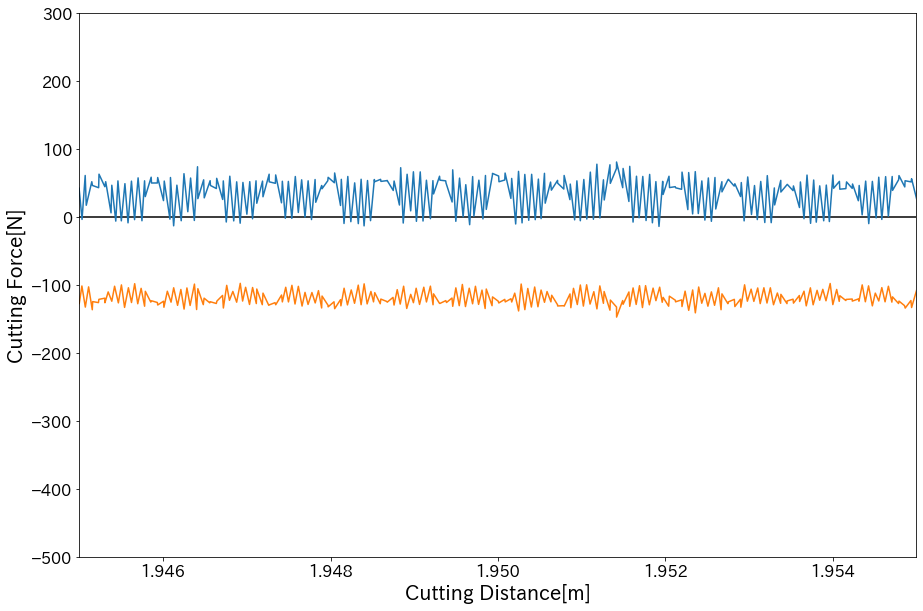

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

#全データ
# p = plt.plot(df['x_d'],df['x'])
# p = plt.plot(df['y_d'],df['y'])
# p = plt.plot(df['z_d'],df['z'])
# ax.set_xlim(0, 12)
# ax.set_ylim(-500,300)

start = 50000
end = 51000

#ある領域
p = plt.plot(df['x_d'][start:end],df['x'][start:end])
p = plt.plot(df['y_d'][start:end],df['y'][start:end])
# p = plt.plot(df['z_d'][start:end],df['z'][start:end])
ax.set_xlim(1.945, 1.955)
ax.set_ylim(-500,300)


p = ax.set_xlabel("Cutting Distance[m]", fontsize=20)
p = ax.set_ylabel("Cutting Force[N]", fontsize=20)
# p = ax.legend(["x","y","z"], fontsize=20)
p = plt.tick_params(labelsize=16)
p = plt.hlines([0],0,12)
fig.savefig("cutting_force_max_24-504_skiprow=400.png")

In [17]:
df['x_d']

0        0.000000
1        0.000073
2        0.000074
3        0.000147
4        0.000153
          ...    
1277    11.881299
1278    11.881340
1279    11.881390
1280    11.881404
1281    11.881443
Name: x_d, Length: 307680, dtype: float64

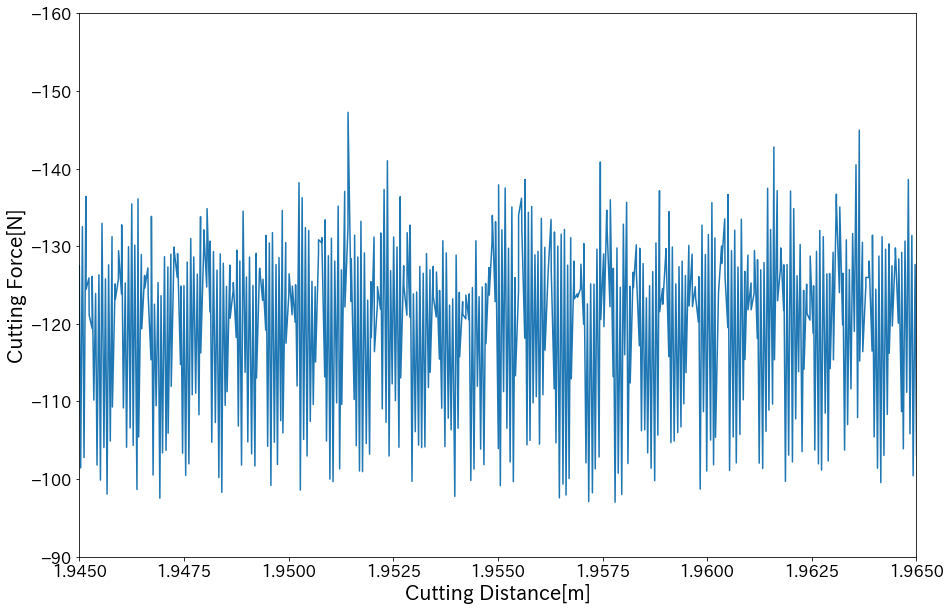

In [23]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

#全データ
# p = plt.plot(df['x_d'],df['x'])
# p = plt.plot(df['y_d'],df['y'])
# p = plt.plot(df['z_d'],df['z'])
# ax.set_xlim(0, 12)
# ax.set_ylim(-500,300)

start = 50000
end = 60000

#ある領域
# p = plt.plot(df['x_d'][start:end],df['x'][start:end])
p = plt.plot(df['y_d'][start:end],df['y'][start:end])
# p = plt.plot(df['z_d'][start:end],df['z'][start:end])
ax.set_xlim(1.945, 1.965)
ax.set_ylim(-90,-160)


p = ax.set_xlabel("Cutting Distance[m]", fontsize=20)
p = ax.set_ylabel("Cutting Force[N]", fontsize=20)
# p = ax.legend(["x","y","z"], fontsize=20)
p = plt.tick_params(labelsize=16)
p = plt.hlines([0],0,12)
fig.savefig("cutting_force_max_24-504_skiprow=400.png")